<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/red-cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4a

# 1 Precision-Recall Curves

## 1.1 Euclidean Distance

In [ ]:
from sklearn.datasets import load_digits
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
digits = load_digits ()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [ ]:
# function measuring the distances between two sets of images, vectorized
def dist_vec(data_):
    return np.linalg.norm(data_[:, None, :] - data_[None, :, :], axis=-1)

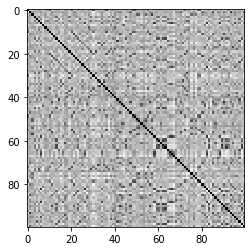

In [ ]:
# to limit th calculation time the number of used instances N can be changed
N = 100  # N = 1797 to include all data
testdata = data[:N]
testlabels = target[:N]

# calculate distance matrix using implementation with vectorization
testdist = dist_vec(testdata)

# display distance matrix as a grayscale image
plt.figure()
plt.gray()
plt.imshow(testdist , interpolation="nearest")
plt.show()

In [ ]:
# returns the positions of the m nearest instances to instance n
def mpos(dist, n, m):
    return np.argsort(dist[n])[:m]

# returns the features of the m nearest instances to instance n
def minst(data, dist, n, m):
    return data[np.argsort(dist[n])[:m]]

# calculates the precision by comparing the labels of the m instances closest to instance n
def precision(dist, n, m, labels):
    pos = mpos(dist, n, m)
    tp = np.count_nonzero(labels[pos] == labels[n]) # true positives
    return tp/m

# calculates the recall by comparing the labels of the m instances closest to instance n
def recall(dist, n, m, labels):
    pos = mpos(dist, n, m)
    tp = np.count_nonzero(labels[pos] == labels[n]) # true positives
    Nn = np.count_nonzero(labels == labels[n]) # number of negatives
    return tp/Nn

In [ ]:
# gives a precision matrix for all combinations m,n
def precisionmatrix(dist, N, labels):
    P = np.array([
        [
            precision(dist, n, m, labels) for n in range(N)
        ] for m in range(1,N+1)
    ])
    return P

# gives a recall matrix for all combinations m,n
def recallmatrix(dist, N, labels):
    R = np.array([
        [
            recall(dist, n, m, labels) for n in range(N)
        ] for m in range(1,N+1)
    ])
    return R

In [ ]:
# calculating the mean of the precision for the different labels
def Pm(N, dist, labels):
    P = precisionmatrix(dist, N, labels)
    return np.array([np.transpose(P)[labels == i].mean(axis = 0) for i in range(10)])

# calculating the mean of the recall for the different labels
def Rm(N, dist, labels):
    R = recallmatrix(dist, N, labels)
    return np.array([np.transpose(R)[labels == i].mean(axis = 0) for i in range(10)])

In [ ]:
# calculating the area under the precision:recall-curve for the different labels
def auc(Pre, Rec):
    auc_ = [0]*10
    for j in range(10):
        for k in range(len(Pre[j])-1):
            # adding up the area under the curve by approximating the area by trapezes
            auc_[j] += -(Rec[j][k+1]+Rec[j][k])/2*(Pre[j][k+1]-Pre[j][k]) 
        # the curve does not end at (0,1) so the auc has to be extended to this point
        auc_[j] += -(1+Rec[j][-1])/2*(0-Pre[j][-1]) 
    return auc_

# plot the precision:recall-curve and print the AUC
def plotauc(Pre, Rec):
    for j in range(10):
        plt.plot(Pre[j], Rec[j], label = j)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc = 'best')
    plt.show()
    print("areas under the curves:", auc(Pm_, Rm_))

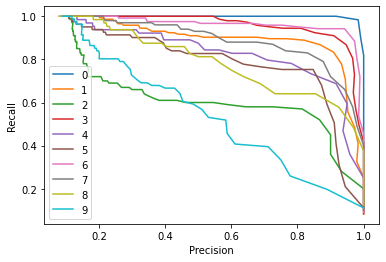

areas under the curves: [0.9977403638185004, 0.9007929094182566, 0.6304926264947156, 0.9599439096210088, 0.8386209856544066, 0.7927018309014756, 0.9643035585183674, 0.8939866981989909, 0.797389472771933, 0.565241484319726]


In [ ]:
Pm_ = Pm(N, testdist, testlabels)
Rm_ = Rm(N, testdist, testlabels)
plotauc(Pm_, Rm_)

In [ ]:
# calculates the precision gain by comparing the labels of the m instances closest to instance n
def precisionGain(dist, n, m, labels):
    pos = mpos(dist, n, m)
    tp = np.count_nonzero(labels[pos] == labels[n])
    prec = tp/m
    N = len(labels)
    Nn = np.count_nonzero(labels == labels[n])
    return max(0, (N/Nn - 1/prec) / (N/Nn - 1))

# calculates the recall gain by comparing the labels of the m instances closest to instance n
def recallGain(dist, n, m, labels):
    pos = mpos(dist, n, m)
    tp = np.count_nonzero(labels[pos] == labels[n])
    N = len(labels)
    Nn = np.count_nonzero(labels == labels[n])
    rec = tp/Nn
    return max(0, (N/Nn - 1/rec) / (N/Nn - 1))

# gives a precision gain matrix for all combinations m,n
def precisionmatrixG(dist, N, labels):
    P = np.array([
        [
            precisionGain(dist, n, m, labels) for n in range(N)
        ] for m in range(1,N+1)
    ])
    return P

# gives a recall gain matrix for all combinations m,n
def recallmatrixG(dist, N, labels):
    P = np.array([
        [
            recallGain(dist, n, m, labels) for n in range(N)
        ] for m in range(1,N+1)
    ])
    return P

# calculating the mean of the precision gain for the different labels
def PmG(N, dist, labels):
    P = precisionmatrixG(dist, N, labels)
    return np.array([np.transpose(P)[labels == i].mean(axis = 0) for i in range(10)])

# calculating the mean of the recall gain for the different labels
def RmG(N, dist, labels):
    R = recallmatrixG(dist, N, labels)
    return np.array([np.transpose(R)[labels == i].mean(axis = 0) for i in range(10)])

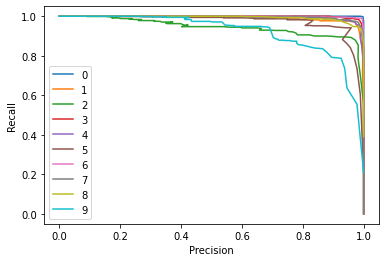

areas under the curves: [0.999956203310157, 0.9907596493647112, 0.9454394920977082, 0.9981335764301252, 0.9933605815908596, 0.9723455950477844, 0.998451669152975, 0.9959003526364818, 0.9935961357211446, 0.9211423502349865]


In [ ]:
Pm_ = PmG(N, testdist, testlabels)
Rm_ = RmG(N, testdist, testlabels)
plotauc(Pm_, Rm_)

## 1.2 Hand-Crafted Distance

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import random

In [ ]:
# to find a function to separate the ten different groups we used a small network with two layers
# (a network with just one layer did not work out)
# the second layer reduces the output to only two features
class TrainNet(nn.Module):
    def __init__(self):
        super(TrainNet, self).__init__()
        self.lin1 = nn.Linear(64, 64)
        self.lin2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [ ]:
net = TrainNet()

In [ ]:
# save the net
torch.save(net.state_dict(), "FMLnet")

In [ ]:
# load the net
net = TrainNet()
net.load_state_dict(torch.load("FMLnet"))

<All keys matched successfully>

In [ ]:
# the network is trained to seperate the groups by sorting them to the following ten points
targpos = [[1,2],[2,1],[2,-1],[1,-2],[-1,-2],[-2,-1],[-2,1],[-1,2],[1,0],[-1,0]]

# training
T = 50 # number of epochs
for k in range(T):
    Loss = 0
    for i in range(len(target)):
        dat = data[i]
        targs = targpos[target[i]]
        input = Variable(torch.Tensor([dat]))
        out = net(input)
        targ = Variable(torch.Tensor([targs]))
        criterion = nn.MSELoss()
        loss = criterion(out, targ)
        net.zero_grad()
        loss.backward()
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        optimizer.step()
        Loss += loss.detach().numpy()
    #print(Loss)

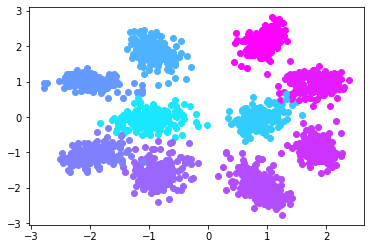

In [ ]:
# visualization of the groups
for i in range(len(target)):
    input = Variable(torch.Tensor([data[i]]))
    out = net(input).detach().numpy()[0]
    plt.plot(out[0], out[1], 'bo', color=(1-target[i]/10,target[i]/10,1,1))
plt.show()

The clusters of the different labels should overlap as little as ppossible.

In [ ]:
# calculating the two features using the trained net
def twofeat(data, labels, n, trainednet):
    data2 = np.array([trainednet(Variable(torch.Tensor([data[i]]))).detach().numpy()[0] for i in range(n)])
    labels2 = labels[:n]
    return data2, labels2

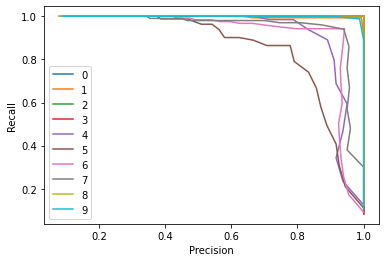

areas under the curves: [0.9999999999999997, 0.9972820385260989, 1.0000000000000002, 0.9999999999999997, 0.9272785401447509, 0.85640978976195, 0.9245263205776136, 0.9535672448241411, 0.9999999999999997, 0.9986968449931413]


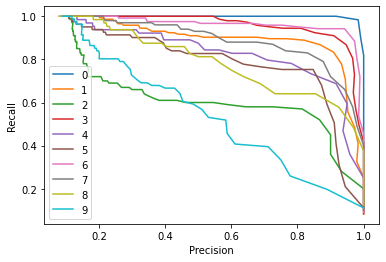

areas under the curves: [0.9977403638185004, 0.9007929094182566, 0.6304926264947156, 0.9599439096210088, 0.8386209856544066, 0.7927018309014756, 0.9643035585183674, 0.8939866981989909, 0.797389472771933, 0.565241484319726]


In [ ]:
# comparing the two methods
N = 100
testdata = data[:N]
testlabels = target[:N]
data2, labels2 = twofeat(data, target, N, net)
dist2 = dist_vec(data2)

Pm_ = Pm(N, dist2, labels2)
Rm_ = Rm(N, dist2, labels2)
plotauc(Pm_, Rm_)

Pm_ = Pm(N, testdist, testlabels)
Rm_ = Rm(N, testdist, testlabels)
plotauc(Pm_, Rm_)

The areas under the curves have improved significantly with the handcrafted features.

# 2 Red cards study

## 2.1 Loading and cleaning the data

In [1]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

from numba import jit
from datetime import datetime, date

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import sklearn

%matplotlib inline
import seaborn as sns    

Import the dataset in dyad format

In [2]:
filename= 'CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

In [3]:
#number of ref-player dyads
df.shape[0]

146028

In [4]:
#number of data points
df["games"].sum()

426572

In [5]:
df[df["games"]>2].head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
46,abdoul-camara,Abdoul Camara,FC Sochaux,France,20.02.1990,177.0,70.0,Left Winger,4,1,2,1,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
48,ahmed-kantari,Ahmed Kantari,Stade Brest,France,28.06.1985,185.0,78.0,NaN,6,4,0,2,0,1,0,0,36844.jpg,0.25,0.25,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
52,alexis-thebaux,Alexis Thébaux,Stade Brest,France,17.03.1985,185.0,81.0,NaN,3,0,1,2,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
58,antoine-devaux,Antoine Devaux,Stade Reims,France,21.02.1985,185.0,72.0,Defensive Midfielder,3,1,1,1,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
59,arnaud-maire,Arnaud Maire,AC Ajaccio,France,06.03.1979,181.0,74.0,NaN,3,1,1,1,0,1,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


We have 426572 player-ref combinations in total, but only 146028 dyads. There are multiple player-referee combinations that met more than once (i.e. there were several games in which both the player and the ref were involved). This complicates the analysis, it would be better to have a datapoint for every time a player and a referee met. Therefore, the disaggregation strategy from Team Sheffield was adopted with a few modifications(https://osf.io/w7tds/)

In [6]:
def transform_data(df):
  #add new vars
  df['allreds']=df['yellowReds']+df['redCards']
  df['allredsStrict']=df['redCards']
  df['refCount']=0

  #transform victory/tie/defeat values to relative rates
  df["victories"] = df["victories"]/df["games"]
  df["ties"] = df["ties"]/df["games"]
  df["defeats"] = df["defeats"]/df["games"]

  #add a column which tracks how many games each ref is involved in
  refs=pd.unique(df['refNum'].values.ravel()) #list all unique ref IDs

  #for each ref, count their dyads
  for r in refs:
      df['refCount'][df['refNum']==r]=len(df[df['refNum']==r])    

  colnames=list(df.columns)

  j = 0
  out = [0 for _ in range(sum(df['games']))]

  for _, row in df.iterrows():
          n = row['games']
          c = row['allreds']
          d = row['allredsStrict']

          
          for _ in range(n):
                  row['allreds'] = 1 if (c-_) > 0 else 0
                  row['allredsStrict'] = 1 if (d-_) > 0 else 0
                  rowlist=list(row)  #convert from pandas Series to prevent overwriting previous values of out[j]
                  out[j] = rowlist
                  j += 1
                  if j%10000==0:    
                      print("Number "+ str(j) + " of " + str(df.shape[0]))

  pd.DataFrame(out, columns=colnames).to_csv('crowdstorm_singles.csv', index=False) 

In [7]:
%%capture 
##added to suppress output
#disaggregate dataframe
transform_data(df)

In [245]:
file_singles= 'crowdstorm_singles.csv'
dfs = pd.read_csv(file_singles)
dfs["games"] = 1 #every row now represents one game
dfs.shape[0]
dfs.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,allreds,allredsStrict,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0.0,0.0,1.0,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0.0,0.0,1.0,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0.0,1.0,0.0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0,0,3
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0,0,3
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0,0,3


We now have one row for every game. We adjusted the games column to only contain 1s since each row now represents one game. We also updated the victories/ties/defeats columns to relative rates. If the dyad occured only once, nothing changes; if the pair was present more often than once, both data points now have the relative rates of those events as features to ensure that the information from those columns is not lost without skewing the data.

The photo ID column is crucial; if there is no photo, we cannot use the data point since there is no skin color rating available. There are 53505 data points without photo id; we drop those. 

We also drop all data points without height because we want to use the height later.

In [246]:
dfs.isna().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             357
weight            3862
position         44196
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          53505
rater1           53505
rater2           53505
refNum               0
refCountry           0
Alpha_3              1
meanIAT            201
nIAT               201
seIAT              201
meanExp            201
nExp               201
seExp              201
allreds              0
allredsStrict        0
refCount             0
dtype: int64

In [247]:
dfs = dfs[dfs['photoID'].notna()]
dfs = dfs[dfs['height'].notna()]
dfs.isna().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height               0
weight            1183
position         21657
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID              0
rater1               0
rater2               0
refNum               0
refCountry           0
Alpha_3              1
meanIAT            187
nIAT               187
seIAT              187
meanExp            187
nExp               187
seExp              187
allreds              0
allredsStrict        0
refCount             0
dtype: int64

Average: 125.29257641921397
Median: 11.0


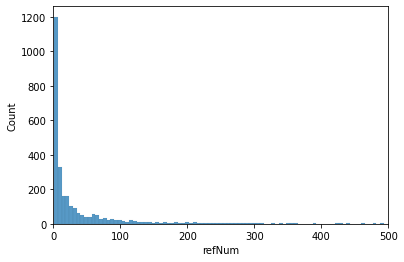

In [248]:
#look at how often a specific ref occurs in the dataframe
sns.histplot(dfs.refNum.value_counts(),kde=False, bins=1000)
plt.xlim(0,500)

#what is the median of the referee occurance?
print("Average: " + str(np.average(dfs.refNum.value_counts())))
print("Median: " + str(np.median(dfs.refNum.value_counts())))

Most of the referees occur only a few times in the whole dataset (median level 11). In a normal game there are 22 players, so each referee with less than 22 occurances seems to be erronous (for example meeting a player during a game not included in the leagues we are looking at). Therefore, we exclude all referees with less than 22 occurances in the dataset.

In [249]:
all_refs = dfs.refNum.value_counts()
good_refs = all_refs[all_refs>21] 
dfs_good=dfs[dfs['refNum'].isin(good_refs.index.values)]

We have the birth date of the players, but more helpful as a feature would be their age. Therefore, we transform this features to become an age.

In [250]:
def age(born):
    born = datetime.strptime(str(born), "%d.%m.%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))

In [251]:
#dfs_good['birthday'] = df['birthday'].astype('str') 
dfs_good["age"] = dfs_good['birthday'].apply(age)
dfs_good.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,allreds,allredsStrict,refCount,age
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0.0,0.0,1.0,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,1,38
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0.0,0.0,1.0,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0,0,1,39
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0.0,0.0,1.0,0,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,30,42
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1.0,0.0,0.0,0,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,30,36
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0.0,0.0,1.0,0,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,30,35


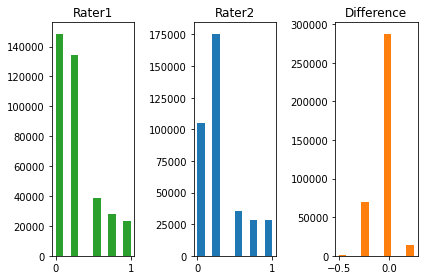

In [252]:
fig, ax = plt.subplots(1,3)
c = sns.color_palette()

ax[0].hist(dfs_good["rater1"], color = c[2])
ax[0].set_title("Rater1")

ax[1].hist(dfs_good["rater2"], color = c[0])
ax[1].set_title("Rater2")

ax[2].hist(dfs_good["rater1"]-dfs_good["rater2"], color = c[1])
ax[2].set_title("Difference")

fig.tight_layout()

There are major differences between the raters, but on most of the ratings they agree. It might therefore be a good idea to use their averaged rating as a feature.

In [253]:
dfs_good["rating"] = (dfs_good["rater1"] + dfs_good["rater2"])/2
dfs_good = dfs_good.drop(["rater1", "rater2", "birthday"], axis=1)
dfs_good.head()

,playerShort,player,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,allreds,allredsStrict,refCount,age,rating
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,177.0,72.0,Attacking Midfielder,1,0.0,0.0,1.0,0,0,0,0,95212.jpg,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,1,38,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,179.0,82.0,Right Winger,1,0.0,0.0,1.0,0,1,0,0,1663.jpg,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0,0,1,39,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,182.0,71.0,Center Back,1,0.0,0.0,1.0,0,0,0,0,3868.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,30,42,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,187.0,80.0,Left Fullback,1,1.0,0.0,0.0,0,0,0,0,47704.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,30,36,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,180.0,68.0,Defensive Midfielder,1,0.0,0.0,1.0,0,0,0,0,22356.jpg,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,30,35,1.000


After further consideration, we supposed that it makes more sense for our regression problem to group the dyad entries by player, that means to sum up all dyads which contain some player into one row. Therefore, we do not use the disaggregation strategy from before, but use a custom aggregation strategy on our own. So to get a good y variable, we have to collapse the data frame so that all occurances of a single player are collapsed into one, no matter the ref.

In this step we will also drop attributes that we don't need anymore. Player names are not needed (we still have playerShort) and we don't want to consider the several football clubs, but only the leagues. We are dropping yellowCards, yellowReds and redCards since we are going to use allreds and allredsStrict instead. Photos and information about the referees are not interesting as well. We are not going to use weight and position because these information are missing for too many data points.

In [254]:
print(dfs_good.shape[0])
aggregation_functions = {'allreds': 'sum', 'allredsStrict': 'sum', 'age': 'first', 'height': 'first', 'games': 'sum', 'victories': 'sum', 'ties': 'sum','defeats': 'sum', 'goals': 'sum', 'rating': 'first', 'leagueCountry': 'first'}
df_new = dfs_good.groupby(dfs_good['playerShort']).aggregate(aggregation_functions)
print(df_new.shape[0])
df_new.head()

372996
1582


,allreds,allredsStrict,age,height,games,victories,ties,defeats,goals,rating,leagueCountry
playerShort,,,,,,,,,,,
aaron-hughes,0,0,42,182.0,654,247.0,179.0,228.0,103,0.125,England
aaron-hunt,1,1,35,183.0,336,141.0,73.0,122.0,584,0.125,Germany
aaron-lennon,0,0,34,165.0,412,200.0,97.0,115.0,387,0.250,England
aaron-ramsey,1,1,31,178.0,260,150.0,42.0,68.0,213,0.000,England
abdelhamid-el-kaoutari,6,2,31,180.0,124,41.0,40.0,43.0,7,0.250,France


To get a good predictive variable (the fraction of games where a given player will receive a red card), we divide the two columns concerning red cards by the number of games.

Afterwards, the number of games can be dropped because it equals the sum of victories, ties and defeats and is redundant.

In [255]:
df_new['allreds'] = df_new['allreds']/df_new['games']
df_new['allredsStrict'] = df_new['allredsStrict']/df_new['games']
df_new = df_new.fillna({'allreds': 0, 'allredsStrict': 0})

df_new = df_new.drop(["games"], axis=1)
df_new.head()

,allreds,allredsStrict,age,height,victories,ties,defeats,goals,rating,leagueCountry
playerShort,,,,,,,,,,
aaron-hughes,0.000000,0.000000,42,182.0,247.0,179.0,228.0,103,0.125,England
aaron-hunt,0.002976,0.002976,35,183.0,141.0,73.0,122.0,584,0.125,Germany
aaron-lennon,0.000000,0.000000,34,165.0,200.0,97.0,115.0,387,0.250,England
aaron-ramsey,0.003846,0.003846,31,178.0,150.0,42.0,68.0,213,0.000,England
abdelhamid-el-kaoutari,0.048387,0.016129,31,180.0,41.0,40.0,43.0,7,0.250,France


We now want to encode the categorical feature **leagueCountry** into a one-hot encoding.

In [256]:
df_new = pd.get_dummies(df_new, columns=['leagueCountry'], prefix=['one_hot'])
df_new.head()

,allreds,allredsStrict,age,height,victories,ties,defeats,goals,rating,one_hot_England,one_hot_France,one_hot_Germany,one_hot_Spain
playerShort,,,,,,,,,,,,,
aaron-hughes,0.000000,0.000000,42,182.0,247.0,179.0,228.0,103,0.125,1,0,0,0
aaron-hunt,0.002976,0.002976,35,183.0,141.0,73.0,122.0,584,0.125,0,0,1,0
aaron-lennon,0.000000,0.000000,34,165.0,200.0,97.0,115.0,387,0.250,1,0,0,0
aaron-ramsey,0.003846,0.003846,31,178.0,150.0,42.0,68.0,213,0.000,1,0,0,0
abdelhamid-el-kaoutari,0.048387,0.016129,31,180.0,41.0,40.0,43.0,7,0.250,0,1,0,0


## 2.2 Model Creation

First, we have to prepare an array containing all features and an array containing the fraction of red cars (allreds).

In [257]:
#preparing data
df_X = df_new.copy()
df_X = df_X.drop(["allreds", "allredsStrict"], axis=1)
x = np.array(df_X)
#x = x.reshape(df_new.shape[0], -1)

y = np.array(df_new["allreds"].copy())
y = y.reshape(-1,1)

# this is used in task 2.4
y2 = np.array(df_new["allredsStrict"].copy())
y2 = y.reshape(-1,1)

Now, we use sklearn to implement and cross-validate the linear regression and the regression forest.

In [258]:
folds = 20

#linear regression
scores_linear = cross_val_score(LinearRegression(), x, y, cv=folds, scoring = "neg_mean_squared_error")

print(f"Average squared error of linear regression: {-np.mean(scores_linear)}")

Average squared error of linear regression: 0.00010487232928811854


In [260]:
#regression forest
def regression_forest(x,y):
  regr = RandomForestRegressor(max_depth=10, random_state=0)
  scores = cross_val_score(regr, x, y.ravel(), cv=folds, scoring = "neg_mean_squared_error")
  return scores

In [223]:
scores_forest = regression_forest(x,y)
print(f"Average squared error of regression forest: {-np.mean(scores_forest)}")

Average squared error of regression forest: 0.00012826629904525946


Comment regarding the results:

## 2.3 Answering the Research Question

In [200]:
def createPermutationSets(X, num, idx):
  assert(isinstance(X, np.ndarray) and len(X) >= 1 and num >= 1 and idx >= 0 and idx < len(X[0]))
  sets = []

  # first dataset is the original
  sets.append(X.copy())

  # create more datasets with shuffled values in column idx
  for n in range(num-1):
    perm = np.random.permutation(len(X))
    copy = X.copy()
    copy[:,idx] = copy[perm, idx] 
    sets.append(copy)

  return sets


In [224]:
# these lists will hold the errors for each model
errs_linear = []
errs_forest = []

# create permuted data sets (the first one is the original)
xs = createPermutationSets(x, 20, 6)

for x_perm in xs:
  score = cross_val_score(LinearRegression(), x_perm, y, cv=folds, scoring = "neg_mean_squared_error")
  errs_linear.append(-np.mean(score))

  score = regression_forest(x_perm, y)
  errs_forest.append(-np.mean(score))

In [240]:
linear_bias = np.sum(errs_linear[1:] > errs_linear[0])
forest_bias = np.sum(errs_forest[1:] > errs_forest[0])

print(f"Linear regression: Test error of the shuffled datasets was higher for {linear_bias} of 19 datasets")
print(f"Regression forest: Test error of the shuffled datasets was higher for {forest_bias} of 19 datasets")

err_linear = errs_linear[0]
err_linear_perm = np.mean(errs_linear[1:])

err_forest = errs_forest[0]
err_forest_perm = np.mean(errs_forest[1:])

print(f"\nAverage error linear regression, original: {err_linear}")
print(f"Average error linear regression, permuted: {err_linear_perm}")
print(f"\nAverage error regression forest, original: {err_forest}")
print(f"Average error regression forest, permuted: {err_forest_perm}")

Linear regression: Test error of the shuffled datasets was higher for 19 of 19 datasets
Regression forest: Test error of the shuffled datasets was higher for 0 of 19 datasets

Average error linear regression, original: 0.00011514876505037573
Average error linear regression, permuted: 0.00011561877131088013

Average error regression forest, original: 0.00012826629904525946
Average error regression forest, permuted: 0.00012619055145690185


## 2.4 How to lie with statistics

In [304]:
x3 = x[:,1:]
#x3 = x[:,1:7]

In [305]:
# these lists will hold the errors for each model
errs_linear = []
errs_forest = []

# create permuted data sets (the first one is the original)
xs = createPermutationSets(x, 20, 4)

for x_perm in xs:
  score = cross_val_score(LinearRegression(), x_perm, y, cv=folds, scoring = "neg_mean_squared_error")
  errs_linear.append(-np.mean(score))

  score = regression_forest(x_perm, y)
  errs_forest.append(-np.mean(score))

In [307]:
linear_bias = np.sum(errs_linear[1:] > errs_linear[0])
forest_bias = np.sum(errs_forest[1:] > errs_forest[0])

print(f"Linear regression: Test error of the shuffled datasets was higher for {linear_bias} of 19 datasets")
print(f"Regression forest: Test error of the shuffled datasets was higher for {forest_bias} of 19 datasets")

err_linear = errs_linear[0]
err_linear_perm = np.mean(errs_linear[1:])

err_forest = errs_forest[0]
err_forest_perm = np.mean(errs_forest[1:])

print(f"\nAverage error linear regression, original: {err_linear}")
print(f"Average error linear regression, permuted: {err_linear_perm}")
print(f"\nAverage error regression forest, original: {err_forest}")
print(f"Average error regression forest, permuted: {err_forest_perm}")

Linear regression: Test error of the shuffled datasets was higher for 19 of 19 datasets
Regression forest: Test error of the shuffled datasets was higher for 5 of 19 datasets

Average error linear regression, original: 0.0001050301684170336
Average error linear regression, permuted: 0.00010544134994012237

Average error regression forest, original: 0.00011616948496172576
Average error regression forest, permuted: 0.00011548305168139163


## 2.5 Alternative hypotheses 

**Hypotheses 1: Age correlates with success (goals per game)**

**Hypotheses 2: Goals correlates with victories**

Reds correlate with ties